# FPGA实践自选项目
# 卷积神经网络实现MNIST书写数字识别

In [1]:
from pynq import Overlay
import numpy as np
import util
from pynq import MMIO
from pynq import Xlnk
import matplotlib.pyplot as plt

In [2]:
overlay = Overlay("./design_1.bit")

xlnk = Xlnk()   
xlnk.xlnk_reset()

### 此处分配内存空间为旧版代码，可能需要更改
### 适用于PYNQv2.4

In [3]:
img_in_b = xlnk.cma_array(shape=(784,), dtype=np.uint8)
in_buffer_address_b=img_in_b.physical_address

img_in_g = xlnk.cma_array(shape=(784,), dtype=np.uint8)
in_buffer_address_g=img_in_g.physical_address

img_in_r = xlnk.cma_array(shape=(784,), dtype=np.uint8)
in_buffer_address_r=img_in_r.physical_address

img_out = xlnk.cma_array(shape=(1,), dtype=np.int32)
out_buffer_address=img_out.physical_address


# print("in_buffer_address_b:",in_buffer_address_b)
# print("in_buffer_address_g:",in_buffer_address_g)
# print("in_buffer_address_r:",in_buffer_address_r)

### 根据BD的分配地址填写

In [4]:
IP_BASE_ADDRESS    =  0x0040000000
ADDRESS_RANGE      =  0x80

FPGA_img_addr_AP_CTRL =0x00
FPGA_img_addr_GIE     =0x04
FPGA_img_addr_IER     =0x08
FPGA_img_addr_ISR     =0x0c
FPGA_img_addr_in_b    =0x10
FPGA_img_addr_in_g    =0x20
FPGA_img_addr_in_r    =0x30
FPGA_img_addr_out     =0x40

### CNN IP DRIVER
### 分配地址，开始计算

In [5]:
def CNN_Init_EX():
    # mapping memory
    mmio = MMIO(IP_BASE_ADDRESS,ADDRESS_RANGE)
    while True:
        ap_idle =  (mmio.read(FPGA_img_addr_AP_CTRL)>>2)&0x01
        if(ap_idle):
            break

    mmio.write(FPGA_img_addr_in_b  ,in_buffer_address_b)
    mmio.write(FPGA_img_addr_in_g  ,in_buffer_address_g)
    mmio.write(FPGA_img_addr_in_r  ,in_buffer_address_r)
    mmio.write(FPGA_img_addr_out  ,out_buffer_address)
    
    mmio.write(FPGA_img_addr_GIE,0)
    mmio.write(FPGA_img_addr_AP_CTRL,1)
    while True:
        ap_done =  (mmio.read(FPGA_img_addr_AP_CTRL)>>1)&0x01
        if(ap_done):
            break

## 读取MNIST数据集

In [6]:
test_data = util.load_data()

In [7]:
index = 0
input_data = test_data[0,:-1]
label      = test_data[0,784]
print(input_data.shape)
print(label)

(784,)
7


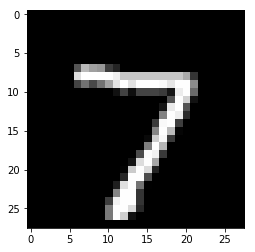

In [8]:
image = input_data
pixels = image.reshape(28,28)
pixels = np.stack([pixels,pixels,pixels],axis = 0)
pixels = np.transpose(pixels,(1,2,0))
plt.imshow(pixels/255, cmap=plt.cm.gray)
plt.show()

### 调用IP 送入数据进行推理

### 输出推理时间和准确率

### num为推理图片数目，上限10000张

In [9]:
import time
cnt = 0
num = 100
start = time.time()
for i in range(num):
    r          = test_data[i,:-1]
    label      = test_data[i,784]
    image_array_r = np.array(r,dtype='uint8')
    np.copyto(img_in_r,image_array_r)
    CNN_Init_EX()
    pred_out = np.zeros(1,dtype = np.int32)
    pred_out = img_out.copy()
#     print("The pred is ",pred_out[0])
#     print("The label is ",label)
    if(pred_out[0] == label):
        cnt += 1
end = time.time()
print(round((end-start)/num*1000,3),'ms/img')
print(cnt/num)

1.283 ms/img
0.89
